In [1]:
import cv2
import os
 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # para desenhar/plotar as tabelas informando os status das peças em cada teste

from fillHoles import fillHoles
from random import randint # used to generate borders to off-limits cropped images
from math import *

from tensorflow import keras

In [2]:
# Load the video file
cap = cv2.VideoCapture('Video2_Vedacao.mp4')

#Flag that checks if the rubber in the image is new or not
first_appearance = True

cont_pecas = 0 
conjunto_video=[]
diametro_ideal_mm = 50
tamanho_da_esteira = 75.6
x_des,y_des = (int(508),int(486))

In [3]:
df = pd.DataFrame()
#test_result lists, for every rubber the test result will be appended here and they will be added as a dataSeries to a dataFrame
Numero_da_peca    = []
Convexidade_valor = [] 
Teste_borda       = []
Teste_superficie  = []
Diametro_Peca     = []
Status_Diametro   = []
Relacao_AB        = []
Status_Raio_AB    = []

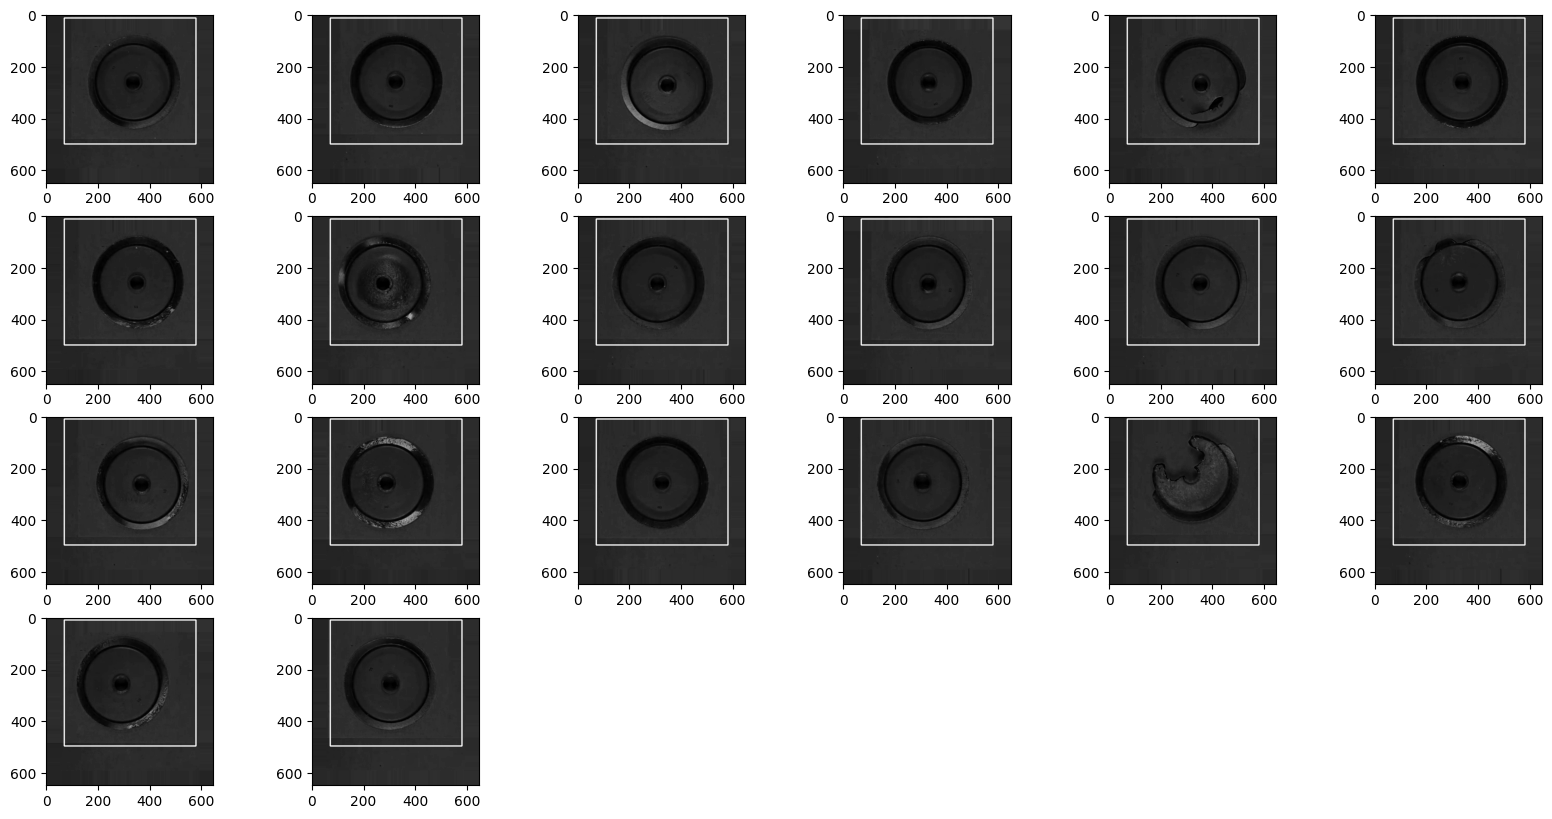

In [4]:
f = plt.figure(figsize=(20,10))
# Loop through the frames in the video
while cap.isOpened():
    # Read the current frame
    ret, frame = cap.read()
        
    if ret:
        # Convert the frame to grayscale
        [B,G,R] = cv2.split(frame)
        (height,width) = R.shape
        
        # Saving output image to be editted in img_text variable
        img1_text = cv2.cvtColor(B,cv2.COLOR_GRAY2RGB)
        img1_text_R = R
        
        # defining and appling thresholds to the image
        returns_borda,thresh_borda       = cv2.threshold(B,90, 255,cv2.THRESH_BINARY_INV)
        returns_diametro,thresh_diametro = cv2.threshold(B,120,255,cv2.THRESH_BINARY_INV)
        thresh_borda = fillHoles(thresh_borda)
        thresh_diametro = fillHoles(thresh_diametro)
        
        
        #find contours in the image
        contours_borda,hierachy_borda=cv2.findContours(thresh_borda,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        contours_diametro,hierachy_diametro=cv2.findContours(thresh_diametro,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        

        #defining the ideal diameter and ideal area in squared pixels
        diametro_ideal_px = diametro_ideal_mm*(width/tamanho_da_esteira)
        raio_ideal_px = int(diametro_ideal_px/2)
        area_circulo_ideal = int(pi*pow(raio_ideal_px,2))
        
        #defining the max countour for both threshes
        if len(contours_diametro) !=0 and len(contours_borda)!=0:
            contorno_max_diametro = max(contours_diametro, key=len)
            contorno_max_borda = max(contours_borda,key=len)
            
            hull = cv2.convexHull(contorno_max_borda, returnPoints=False)
            
            if len(contorno_max_diametro)>=5 and len(contorno_max_borda)>=5: #necessita de no mínimo 5 para fazer fit ellipse
                ellipse = cv2.fitEllipse(contorno_max_diametro)
                (x, y), (MA, ma),angle =  ellipse

                area_contorno = cv2.contourArea(contorno_max_diametro)

                #runs the tests and lowers the first_appearance flag    
                if y > 200 and y< 300 and first_appearance and area_contorno>30000:
                    
                    first_appearance = False

                    ##### Teste diametro
                    diametro=(MA + ma)/width*tamanho_da_esteira/2
                    Diametro_Peca.append(diametro)
                    
                    if diametro<50.5 and diametro>49.5:
                        Status_Diametro.append("Diametro OK")
                    else:
                        Status_Diametro.append("Diametro NOK")
                    
                    ##### Teste A/B elipses
                    elipseAB = MA/ma
                    Relacao_AB.append(elipseAB)
                    
                    if MA/ma>0.95 and MA/ma<1.05:
                        Status_Raio_AB.append("A/B OK")
                    else:
                        Status_Raio_AB.append("A/B NOK")
                    
                    ##### Teste de contornos antigo
                    #area_contorno = cv2.contourArea(contorno_max_borda)
                    #area_hull = cv2.contourArea(hull)
                    
                    #if area_hull>0:
                    #    convexidade = area_contorno/area_hull
                    #    #convexidade = area_contorno/area_circulo_ideal
                    #    Convexidade_valor.append(convexidade)
                    #
                    #if convexidade>0.95:
                    #    Teste_borda.append("Contorno OK")
                    #else:
                    #    Teste_borda.append("Contorno NOK")
                    
                    ##### Teste de contornos novo (via Convexity Defects)
                    # Tutorial e referencia: https://medium.com/analytics-vidhya/contours-and-convex-hull-in-opencv-python-d7503f6651bc
                    
                    defects = cv2.convexityDefects(contorno_max_borda, hull)
                    max_defect = 0 #finds the largest distance between contour and hull
                    #print (defects) #mede a maior distancia entre contorno e borda
                    for element in defects:
                        #print("far",element[0][2])
                        #print("depth",element[0][3])
                        far = element[0][2]
                        depth = element[0][3]
                        if depth - far > max_defect:
                            max_defect = depth - far
                    
                    #print (len(defects))
                    if max_defect < 1000:
                        Teste_borda.append('OK')
                    else:
                        Teste_borda.append('NOK')
                        
                    #generating cropped images in order to make the ML model work:
                    #documentation used for this part: https://docs.opencv.org/3.4/dc/da3/tutorial_copyMakeBorder.html
                    #documentation used for this part: https://stackoverflow.com/questions/55733086/opencv-how-to-overcrop-an-image
                    
                    #prepparing the image in order to crop it:
                    src = img1_text_R
                    borderType = cv2.BORDER_REPLICATE
                    boarderSize = .1
                    top = int(boarderSize * src.shape[0])  # shape[0] = rows
                    bottom = int(boarderSize * src.shape[0])
                    left = int(boarderSize * src.shape[1])  # shape[1] = cols
                    right = left    
                    value = [randint(0,255), randint(0,255), randint(0,255)]
                    dst = cv2.copyMakeBorder(src, top, bottom, left, right, borderType, None, value)
                    
                    #actually cropping the image
                    border_height = dst.shape[0]
                    border_width = dst.shape[1]
                    x_offset = 0
                    y_offset = -70
                    x_min_border = int((border_width - x_des)/2) + x_offset
                    y_min_border = int((border_height - y_des)/2) + y_offset
                    x_max_border = int((border_width + x_des)/2) + x_offset
                    y_max_border = int((border_height  + y_des)/2) + y_offset
                    
                    dst_rect = cv2.rectangle(dst, (x_min_border, y_min_border), (x_max_border, y_max_border), (255, 0, 0), 3)
                    #cv2.rectangle(dst, (int((border_width - x_des)/2), int((border_height - y_des)/2)+20), (int((border_width + x_des)/2),int((border_height + y_des)/2)+20), (255, 0, 0), 3)
                    
                    #o comando de crop image funciona na base de (y,x) e não (x,y)
                    #documentação: https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
                    cropped_image = dst[y_min_border: y_max_border, x_min_border: x_max_border]
                    
                    # Display cropped imagem on a separate window
                    cv2.imshow("Cropped video screenshot", cropped_image)
                    
                    
                    ##### raises and register the count
                    cont_pecas += 1
                    Numero_da_peca.append(cont_pecas)
                    
                    ax = f.add_subplot (4,6,cont_pecas)
                    #plt.imshow(B, cmap='gray')
                    #plt.imshow(thresh, cmap='gray')
                    #plt.imshow(img1_text, cmap='gray')
                    plt.imshow(dst_rect, cmap='gray')
                    conjunto_video.append(cropped_image)
                    
                #raises the first_appearance flag
                if area_contorno<30000 and y>400:
                    first_appearance = True

            #Calculate the moments of the contour and finds its center
            M = cv2.moments(contorno_max_diametro)

            if M["m00"] > 0: #avoid crashes caused by a division by zero
                cX = (M["m10"] / M["m00"])
                cY = (M["m01"] / M["m00"])

            #returnPoints needs to be false in order to ConvexityDefects work: https://stackoverflow.com/questions/52099356/opencvconvexitydefects-on-largest-contour-gives-error
             
            cv2.drawContours(img1_text,contorno_max_borda,-1,(0,255,255),2)
            #cv2.drawContours(img1_text,contorno_max_diametro,-1,(255,0,0),2)
            
            #cv2.drawContours(img1_text,hull,-1,(0,255,0),8)
            
            #track countour center
            #cv2.circle(img1_text, (int(cX), int(cY)), int((MA+ma)/4), (255, 255, 255), 5)
            cv2.circle(img1_text, (int(cX), int(cY)), raio_ideal_px, (0, 0, 255), 5)
            #cv2.rectangle(img1_text, (int(cX)-raio_ideal_px, int(cY)-raio_ideal_px), (int(cX)+raio_ideal_px, int(cY)+raio_ideal_px), (0, 255, 0), 2)
            cv2.putText(img1_text, str(cont_pecas), (int(cX), int(cY)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            
        #also, if there are no countours detected in the image it raises the first appearance flag
        else:
            first_appearance = True
            
        # Display the resulting image
        #cv2.imshow('Blob Detection', thresh)
        cv2.imshow('Video Output', img1_text)
        
        # Wait for a key press to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

plt.show()

In [9]:
conjunto_video=np.stack(conjunto_video, axis=0)
model=keras.models.load_model('./superficie_video.h5')
superficie = model.predict(conjunto_video)
#print(model.predict(conjunto_video))
superficie_results = np.where(superficie==1,"OK","NOK")
print (superficie_results)

1/1 [==============================] - 1s 522ms/step
[['OK']
 ['OK']
 ['OK']
 ['OK']
 ['OK']
 ['OK']
 ['OK']
 ['NOK']
 ['OK']
 ['OK']
 ['OK']
 ['OK']
 ['NOK']
 ['NOK']
 ['OK']
 ['OK']
 ['OK']
 ['NOK']
 ['NOK']
 ['OK']]


In [10]:
df["Numero da Peca"]     = Numero_da_peca
df["Teste borda"]        = Teste_borda
df["Diametro"]           = Diametro_Peca
df["Status Diam"]        = Status_Diametro
df["Relação A/B"]        = Relacao_AB
df["Status A/B"]         = Status_Raio_AB
df["Superfície"]         = superficie_results

print(df)

    Numero da Peca Status borda   Diametro Status Diametro       A/B   
0                1          NOK  49.592789     Diametro OK  0.994207  \
1                2           OK  49.759274     Diametro OK  0.992213   
2                3          NOK  48.732162    Diametro NOK  0.933544   
3                4           OK  45.765247    Diametro NOK  0.999289   
4                5          NOK  48.060501    Diametro NOK  0.929338   
5                6           OK  49.701211     Diametro OK  0.992546   
6                7          NOK  49.311689    Diametro NOK  0.993245   
7                8          NOK  49.402485    Diametro NOK  0.992521   
8                9           OK  49.845697     Diametro OK  0.997392   
9               10          NOK  48.125436    Diametro NOK  0.954454   
10              11          NOK  49.293155    Diametro NOK  0.986553   
11              12          NOK  48.641047    Diametro NOK  0.975949   
12              13          NOK  49.086744    Diametro NOK  0.95

In [ ]:
for i in 